In [1]:
from data_loader import TimeWindowSegmenter


In [2]:
data_processor = TimeWindowSegmenter(
  df_path="wsidm.parquet",
  window_size=10,   # 10 sekund
  step_size=10,     # 10 sekund - ramki się nie pokrywają w danych
)

fix timestamps
end of fixing timestamps


In [23]:
import numpy as np
from scipy.signal import welch
from scipy.fft import fft
import librosa
import pandas as pd

In [ ]:
def dominant_frequency(signal, fs=20):
    """
    Dominująca częstotliwość to ta składowa częstotliwościowa sygnału, 
    która posiada największą moc (czyli największą amplitudę w widmie mocy). 
    Jest to częstotliwość, która dominuje energetycznie w analizowanym odcinku czasu.
    """
    freqs, psd = welch(signal, fs, nperseg=len(signal))
    dom_freq = freqs[np.argmax(psd)]
    return dom_freq

In [ ]:
def spectral_entropy(signal, fs=20):
    """
     Entropia widmowa to miara nieuporządkowania lub losowości rozkładu widmowego sygnału. 
     Bazuje na teorii informacji (entropii Shannona) i opisuje, jak równomiernie rozłożona 
     jest energia sygnału w domenie częstotliwości.

     - Niska entropia oznacza, że energia jest skoncentrowana wokół kilku częstotliwości — sygnał jest bardziej "uporządkowany".
     - Wysoka entropia sugeruje rozproszenie energii po wielu częstotliwościach — sygnał jest bardziej "chaotyczny"
    """
    _, psd = welch(signal, fs, nperseg=len(signal))
    psd_norm = psd / np.sum(psd)  # normalizacja
    entropy = -np.sum(psd_norm * np.log2(psd_norm + 1e-12))  # dodajemy epsilon żeby uniknąć log(0)
    entropy /= np.log2(len(psd_norm))  # normalizacja do [0,1]
    return entropy

In [6]:
def spectral_energy(signal):
    """
    Energia widmowa to całkowita suma energii zawarta w widmie sygnału. 
    Można ją rozumieć jako "siłę" sygnału rozłożoną w dziedzinie częstotliwości.
    
    - Pomaga ocenić ogólną intensywność sygnału — im większa energia, tym silniejszy 
    jest sygnał w danym zakresie czasu.
    """
    spectrum = np.abs(fft(signal))**2
    energy = np.sum(spectrum) / len(spectrum) # normalizujemy do długości sygnału
    return energy

In [10]:
def spectral_centroid(signal, fs=20):
    """
    Centroid widmowy to "środek ciężkości" widma sygnału — informuje, gdzie 
    w domenie częstotliwości skoncentrowana jest energia.

    - Niski centroid: energia skupiona w niskich częstotliwościach (np. wolne ruchy).
    - Wysoki centroid: energia przesunięta w wyższe pasma.
    """
    freqs, psd = welch(signal, fs, nperseg=len(signal))
    psd_norm = psd / np.sum(psd)
    centroid = np.sum(freqs * psd_norm)
    return centroid

In [11]:
def spectral_bandwidth(signal, fs=20):
    """
    Szerokość pasma — odchylenie standardowe widma względem środka ciężkości (centroidu).

    - Małe pasmo sugeruje, że sygnał zawiera głównie wąski zakres częstotliwości.
    - Duże pasmo oznacza obecność wielu różnych składowych częstotliwościowych — np. złożone sygnały biologiczne.
    """
    freqs, psd = welch(signal, fs, nperseg=len(signal))
    psd_norm = psd / np.sum(psd)
    centroid = np.sum(freqs * psd_norm)
    bandwidth = np.sqrt(np.sum(((freqs - centroid) ** 2) * psd_norm))
    return bandwidth

In [12]:
def spectral_flatness(signal, fs=20):
    """
    Spłaszczenie widmowe to miara „szumowatości” sygnału. 
    - Wartość bliska 1: rozłożona energia, przypomina szum.
    - Wartość bliska 0: jedna dominująca częstotliwość (ton).
    """
    _, psd = welch(signal, fs, nperseg=len(signal))
    geometric_mean = np.exp(np.mean(np.log(psd + 1e-12)))  # epsilon zapobiega log(0)
    arithmetic_mean = np.mean(psd)
    flatness = geometric_mean / (arithmetic_mean + 1e-12)
    return flatness

In [13]:
def spectral_slope(signal, fs=20):
    """
    Nachylenie widmowe to kierunek trendu widma — informuje, czy amplitudy 
    rosną czy maleją wraz ze wzrostem częstotliwości.
    
    - Dodatnie: więcej energii w wyższych częstotliwościach.
    - Ujemne: dominacja niższych pasm.
    """
    freqs, psd = welch(signal, fs, nperseg=len(signal))
    X = freqs
    Y = 10 * np.log10(psd + 1e-12)
    slope = np.polyfit(X, Y, 1)[0]  # nachylenie regresji liniowej
    return slope

In [14]:
def spectral_rolloff(signal, fs=20, roll_percent=0.85):
    """
    Częstotliwość roll-off to taka, poniżej której znajduje się X% całkowitej energii.
    
    - Pomaga określić „górne pasmo” sygnału.
    - Typowe wartości X: 0.85 lub 0.95
    """
    freqs, psd = welch(signal, fs, nperseg=len(signal))
    cumulative_energy = np.cumsum(psd)
    threshold = roll_percent * cumulative_energy[-1]
    rolloff_idx = np.where(cumulative_energy >= threshold)[0][0]
    rolloff_freq = freqs[rolloff_idx]
    return rolloff_freq

In [15]:
def band_energy_ratio(signal, fs=20, low_band=(0.0, 10.0), high_band=(10.0, 20.0)):
    """
    Stosunek energii w dwóch zakresach częstotliwości — np. [0–10 Hz] vs. [10–20 Hz].
    - Przydatne do odróżniania typów ruchu (np. chód vs. bieganie).
    """
    freqs, psd = welch(signal, fs, nperseg=len(signal))

    low_mask = (freqs >= low_band[0]) & (freqs < low_band[1])
    high_mask = (freqs >= high_band[0]) & (freqs < high_band[1])

    low_energy = np.sum(psd[low_mask])
    high_energy = np.sum(psd[high_mask])
    
    ratio = low_energy / (high_energy + 1e-12)
    return ratio

In [16]:
def mfcc_features(signal, fs=50, n_mfcc=13):
    """
    Oblicza współczynniki MFCC dla danego sygnału. 
    UWAGA: MFCC ma sens tylko jak będziemy mieć większe FS niż 50Hz.

    Parametry:
    - signal: 1D array – sygnał wejściowy z jednej osi czujnika
    - fs: int – częstotliwość próbkowania (Hz), domyślnie 100 Hz
    - n_mfcc: int – liczba współczynników MFCC do zwrócenia

    Zwraca:
    - wektor cech: średnie wartości każdego z n_mfcc współczynników
    """
    mfcc = librosa.feature.mfcc(y=signal.astype(float), sr=fs, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc, axis=1)  # uśredniamy po czasie
    return mfcc_mean

In [21]:
def extract_features_from_window(window, fs=20):
    features = []
    feature_names = []
    axes = ['ac_x', 'ac_y', 'ac_z', 'g_x', 'g_y', 'g_z']
    
    funcs = [
        ('dom_freq', dominant_frequency, [fs]),    
        ('entropy', spectral_entropy, [fs]),       
        ('energy', spectral_energy, []),           
        ('centroid', spectral_centroid, [fs]),     
        ('bandwidth', spectral_bandwidth, [fs]),   
        ('flatness', spectral_flatness, [fs]),     
        ('slope', spectral_slope, [fs]),           
        ('rolloff', spectral_rolloff, [fs]),       
        ('band_ratio', band_energy_ratio, [fs])    
    ]
    
    for axis in axes:
        signal = window[axis].astype(float).values
        for fname, func, extra_args in funcs:
            features.append(func(signal, *extra_args))
            feature_names.append(f"{axis}_{fname}")
    
    return features, feature_names

In [ ]:
X = []
Y = []
feature_names = None
for window in data_processor.segment():
    features, current_feature_names = extract_features_from_window(window)
    if feature_names is None:
        feature_names = current_feature_names
    label = window['Activity Label'].mode()[0]
    X.append(features)
    Y.append(label)

Segmenting: 100%|██████████| 250/250 [00:19<00:00, 12.62it/s]


In [24]:
features_df = pd.DataFrame(X, columns=feature_names)
features_df['label'] = Y

In [25]:
features_df

,ac_x_dom_freq,ac_x_entropy,ac_x_energy,ac_x_centroid,ac_x_bandwidth,ac_x_flatness,ac_x_slope,ac_x_rolloff,ac_x_band_ratio,ac_y_dom_freq,...,g_z_dom_freq,g_z_entropy,g_z_energy,g_z_centroid,g_z_bandwidth,g_z_flatness,g_z_slope,g_z_rolloff,g_z_band_ratio,label
0,1.3,0.483747,5197.094071,2.211988,2.127930,0.152184,-0.414171,3.2,14548.842979,2.6,...,1.3,0.477894,700.500160,1.745977,1.346696,0.091730,-1.697626,2.5,1.111383e+04,jogging
1,1.3,0.534395,6012.969788,1.982951,1.763206,0.138985,-1.084607,2.6,846.153675,2.6,...,1.3,0.364055,922.877970,1.551187,0.975226,0.048895,-1.434099,1.4,6.099058e+03,jogging
2,1.2,0.440927,6153.479572,1.755256,1.530200,0.119331,-1.071413,2.4,489432.225896,2.5,...,1.3,0.383075,928.394117,1.434671,0.884205,0.048784,-1.954359,1.3,1.256587e+04,jogging
3,1.3,0.471498,7823.257321,2.097153,1.876074,0.135096,-0.259951,2.6,1875.637923,2.5,...,1.3,0.507960,1191.271070,1.750354,1.235658,0.110080,-1.941174,2.5,7.742417e+03,jogging
4,1.3,0.500361,7769.688932,1.954715,1.698712,0.119240,-1.157793,2.6,13386.808911,2.5,...,1.3,0.354522,1523.685387,1.508183,0.809144,0.045773,-1.921978,1.4,2.883398e+04,jogging
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4629,1.9,0.614466,38411.544763,1.427142,1.304697,0.094251,-2.322954,2.0,137485.378337,0.9,...,1.0,0.341772,3546.413480,1.055981,0.569005,0.015362,-3.475706,1.0,2.345755e+06,walking
4630,2.0,0.566765,45511.859992,2.105939,1.230247,0.118740,-1.886110,2.6,49725.204003,1.0,...,1.0,0.294837,3279.440105,1.114555,0.527553,0.012050,-3.083012,1.1,6.149590e+05,walking
4631,0.1,0.397476,18779.818012,0.357023,0.644968,0.018656,-3.137074,0.7,97077.817348,0.2,...,1.0,0.590062,1197.127513,0.928893,0.684388,0.029817,-3.584319,1.1,1.399125e+04,walking
4632,0.1,0.463099,11621.851249,0.432016,0.859173,0.037946,-2.585967,1.0,406665.848942,0.1,...,1.0,0.583888,1027.946566,0.987466,0.784929,0.034722,-3.713101,1.2,5.573681e+04,walking


In [35]:
correlation_matrix = features_df.drop('label', axis=1).corr()
correlation_matrix

,ac_x_dom_freq,ac_x_entropy,ac_x_energy,ac_x_centroid,ac_x_bandwidth,ac_x_flatness,ac_x_slope,ac_x_rolloff,ac_x_band_ratio,ac_y_dom_freq,...,g_y_band_ratio,g_z_dom_freq,g_z_entropy,g_z_energy,g_z_centroid,g_z_bandwidth,g_z_flatness,g_z_slope,g_z_rolloff,g_z_band_ratio
ac_x_dom_freq,1.000000,0.365039,0.046846,0.709858,0.233676,0.391904,0.495188,0.503743,-0.011998,0.329232,...,-0.010178,0.170728,0.083004,0.132007,0.186708,0.108106,0.093183,0.124447,0.162268,0.003328
ac_x_entropy,0.365039,1.000000,-0.248939,0.740007,0.754105,0.899484,0.421100,0.806194,-0.021628,0.108017,...,-0.008029,0.347427,0.532786,-0.147795,0.506101,0.459548,0.471327,0.326080,0.504178,0.005125
ac_x_energy,0.046846,-0.248939,1.000000,-0.101399,-0.332567,-0.348973,-0.129879,-0.211402,0.013369,-0.037551,...,0.008419,-0.286567,-0.590538,0.339402,-0.505626,-0.579655,-0.541949,-0.474649,-0.533570,0.011416
ac_x_centroid,0.709858,0.740007,-0.101399,1.000000,0.715144,0.796156,0.801882,0.920040,-0.023099,0.370861,...,-0.017300,0.381931,0.319116,0.049436,0.473901,0.360488,0.340066,0.353827,0.440616,0.005188
ac_x_bandwidth,0.233676,0.754105,-0.332567,0.715144,1.000000,0.829766,0.737403,0.882015,-0.020457,0.147392,...,-0.015912,0.426685,0.503209,-0.084610,0.603428,0.542334,0.520968,0.497000,0.588687,0.009491
ac_x_flatness,0.391904,0.899484,-0.348973,0.796156,0.829766,1.000000,0.600474,0.867620,-0.020665,0.158211,...,-0.013004,0.443635,0.600798,-0.109508,0.639649,0.584978,0.588293,0.489285,0.633419,-0.000361
ac_x_slope,0.495188,0.421100,-0.129879,0.801882,0.737403,0.600474,1.000000,0.781324,-0.028297,0.349107,...,-0.022908,0.366784,0.249327,0.043791,0.467661,0.363835,0.315344,0.438339,0.430449,0.002819
ac_x_rolloff,0.503743,0.806194,-0.211402,0.920040,0.882015,0.867620,0.781324,1.000000,-0.025437,0.270310,...,-0.016307,0.420366,0.422288,-0.019044,0.558509,0.459144,0.443948,0.423639,0.533830,0.010177
ac_x_band_ratio,-0.011998,-0.021628,0.013369,-0.023099,-0.020457,-0.020665,-0.028297,-0.025437,1.000000,-0.011490,...,0.051789,-0.013848,-0.026015,0.012872,-0.024451,-0.019026,-0.017508,-0.006359,-0.022630,-0.000310
ac_y_dom_freq,0.329232,0.108017,-0.037551,0.370861,0.147392,0.158211,0.349107,0.270310,-0.011490,1.000000,...,-0.015460,0.091895,-0.017102,0.223829,0.090687,0.044790,-0.013951,0.123541,0.060499,-0.003427


In [ ]:
averaged_features = []

methods = ['dom_freq', 'entropy', 'energy', 'centroid', 'bandwidth', 'flatness', 'slope', 'rolloff', 'band_ratio']
sensors = ['ac', 'g']

for method in methods:
    for sensor in sensors:
        columns_to_average = [col for col in features_df.columns if method in col and sensor in col]
        
        averaged_value = features_df[columns_to_average].mean(axis=1)
        
        averaged_features.append(averaged_value)

averaged_df = pd.DataFrame(averaged_features).T
averaged_df.columns = [f"{method}_{sensor}" for method in methods for sensor in sensors]

correlation_matrix = averaged_df.corr()

correlation_matrix

,dom_freq_ac,dom_freq_g,entropy_ac,entropy_g,energy_ac,energy_g,centroid_ac,centroid_g,bandwidth_ac,bandwidth_g,flatness_ac,flatness_g,slope_ac,slope_g,rolloff_ac,rolloff_g,band_ratio_ac,band_ratio_g
dom_freq_ac,1.000000,0.486978,0.376445,0.170665,0.170855,0.173535,0.783695,0.536915,0.315007,0.348334,0.442838,0.272446,0.613337,0.453867,0.590216,0.473327,-0.015811,0.003110
dom_freq_g,0.486978,1.000000,0.439496,0.468932,-0.078437,-0.072259,0.627082,0.771451,0.504428,0.536487,0.536198,0.547950,0.557161,0.551898,0.600632,0.682376,-0.019550,-0.002817
entropy_ac,0.376445,0.439496,1.000000,0.659941,-0.400481,-0.392978,0.704967,0.552981,0.772442,0.499905,0.912005,0.567429,0.442832,0.276263,0.800010,0.561184,-0.027200,0.001452
entropy_g,0.170665,0.468932,0.659941,1.000000,-0.441435,-0.441390,0.436231,0.745723,0.642122,0.821022,0.706422,0.885786,0.367355,0.494194,0.557548,0.800691,-0.041714,-0.016914
energy_ac,0.170855,-0.078437,-0.400481,-0.441435,1.000000,0.998226,-0.009193,-0.115393,-0.334295,-0.182600,-0.369537,-0.334328,0.034991,0.130627,-0.187217,-0.172660,0.005502,-0.006711
energy_g,0.173535,-0.072259,-0.392978,-0.441390,0.998226,1.000000,-0.008879,-0.115192,-0.333367,-0.187937,-0.364474,-0.336641,0.028715,0.122893,-0.186226,-0.173885,0.006001,-0.006808
centroid_ac,0.783695,0.627082,0.704967,0.436231,-0.009193,-0.008879,1.000000,0.759330,0.739965,0.587534,0.794995,0.532486,0.859946,0.602968,0.934050,0.715683,-0.027259,-0.000931
centroid_g,0.536915,0.771451,0.552981,0.745723,-0.115393,-0.115192,0.759330,1.000000,0.697982,0.871150,0.700635,0.859320,0.735495,0.804276,0.762158,0.972744,-0.034103,-0.010237
bandwidth_ac,0.315007,0.504428,0.772442,0.642122,-0.334295,-0.333367,0.739965,0.697982,1.000000,0.693823,0.873094,0.690466,0.760070,0.540851,0.901419,0.722687,-0.025946,0.001231
bandwidth_g,0.348334,0.536487,0.499905,0.821022,-0.182600,-0.187937,0.587534,0.871150,0.693823,1.000000,0.655761,0.924298,0.620451,0.845512,0.645570,0.931661,-0.027514,-0.016168


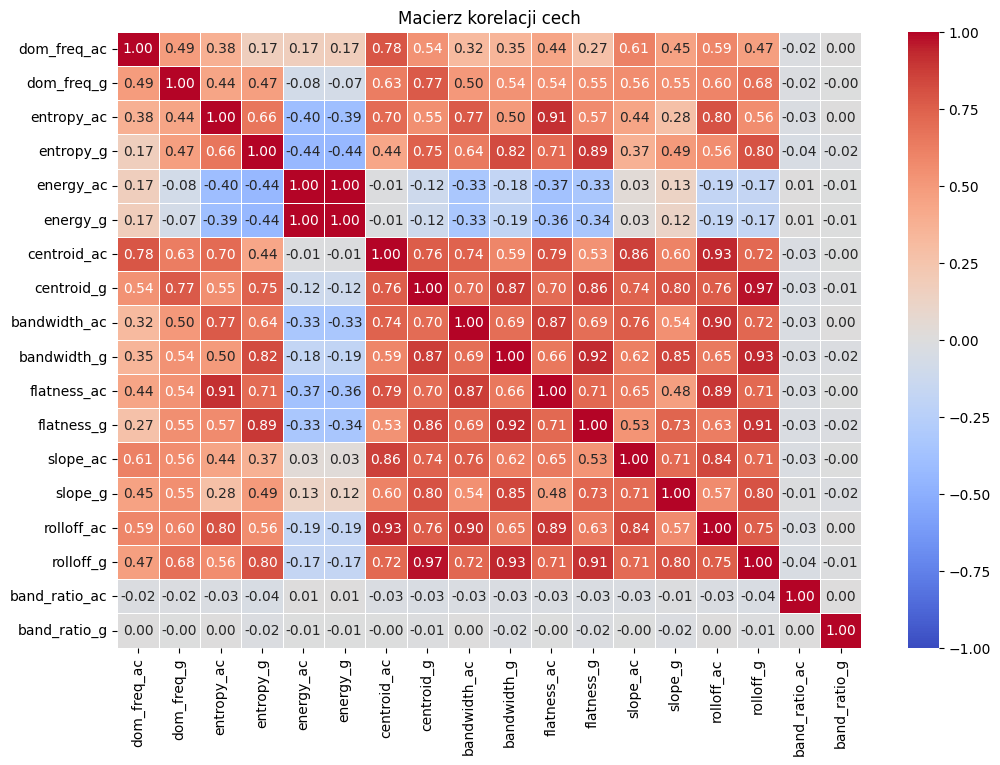

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, vmin=-1, vmax=1)

plt.title('Macierz korelacji cech')
plt.show()